# Análisis de errores en PIONIER (6 meses)

Este notebook analiza las observaciones con `ERROR = True` del instrumento
**PIONIER** durante un periodo de 6 meses. El objetivo es identificar los
`TPL_ID` con mayor cantidad de errores, estudiar sus parámetros numéricos y
categóricos y aplicar clustering para determinar si existen distintos tipos
de errores dentro del instrumento.


In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt

# Importar funciones externalizadas de la carpeta 'src'
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.visualizacion import graficos_por_columna
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory 
from src.clustering import cluster_todos_en_conjunto,plot_clusters_por_cluster_y_origen

plt.style.use('default')
plt.rcParams['font.size'] = 10

## Carga del dataset y filtrado de observaciones con error

Se cargan los parlogs de PIONIER mediante `ParlogsObservations`, obteniendo:

- `df_meta`: información por observación  
- `df_traces`: información por traza  

Luego se filtran únicamente las observaciones donde `ERROR = True`, las cuales
constituyen la base del análisis.


In [2]:
INSTRUMENT='PIONIER'
RANGE='6m'

In [3]:
config = {
    'period': RANGE,
    'system': INSTRUMENT,
    'source': "Instrument",
    'dataset_dir': "../../data"
}
logs = ParlogsObservations(**config)
#logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

In [4]:
df_meta = logs.meta
df_meta = df_meta[ df_meta['ERROR'] == True]
df_traces = logs.traces()
df_traces = df_traces[df_traces['trace_id'].isin(df_meta.index)]
TPL_IDs = logs.meta['TPL_ID'].value_counts()

## TPL_ID con mayor número de errores

A partir de `df_meta` se determina cuántas observaciones con error tiene cada
`TPL_ID`. Para centrarse en casos representativos y con volumen suficiente,
solo se consideran los `TPL_ID` con **25 o más errores** en los análisis
estadísticos y de clustering.


In [5]:
tpl_counts_err = df_meta['TPL_ID'].value_counts()
print("TPL_ID con errores más frecuentes:")
display(tpl_counts_err.head(10))

TPL_ID con errores más frecuentes:


TPL_ID
PIONIER_acq                209
PIONIER_gen_tec_scan        50
PIONIER_gen_tec_ptc         10
PIONIER_gen_tec_setup        4
PIONIER_obs_calibrator       1
PIONIER_gen_tec_niobate      1
PIONIER_obs_science          1
Name: count, dtype: int64

In [6]:
MIN_ERR_POR_TPL = 25

tpl_ids_validos = tpl_counts_err[tpl_counts_err >= MIN_ERR_POR_TPL].index.tolist()
print("TPL_ID usados en TODAS las figuras:", tpl_ids_validos)


TPL_ID usados en TODAS las figuras: ['PIONIER_acq', 'PIONIER_gen_tec_scan']


## Extracción de parámetros numéricos

Para cada `TPL_ID` seleccionado se extraen los parámetros numéricos asociados
a las trazas.  

Antes de ser usados se aplican los siguientes criterios:

- columnas con más del 50% de `NaN` se descartan,  
- filas con demasiados valores faltantes también se eliminan,  
- parámetros constantes se omiten por no aportar información.

El resultado es un conjunto de dataframes limpios que describen el
comportamiento numérico de cada `TPL_ID` con error.


In [7]:
tpl_params_dict_err = {}
threshold_nan = 0.5

for tpl_id in df_meta['TPL_ID'].unique():
    # Solo con error
    params_df_err = extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id=tpl_id)
    if params_df_err is None:
        params_df_err = pd.DataFrame()
    params_df_err = params_df_err.loc[:, params_df_err.isna().mean() < threshold_nan]
    params_df_err = params_df_err.loc[params_df_err.isna().mean(axis=1) < threshold_nan, :]
    if not params_df_err.empty:
        tpl_params_dict_err[tpl_id] = params_df_err

print(f"Se extrajeron parámetros numéricos para {len(tpl_params_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros numéricos para 6 TPL_ID con errores.


## Visualización de parámetros numéricos (histogramas)

Los parámetros numéricos se visualizan mediante histogramas para observar:

- la forma de la distribución,
- diferencias entre casos con y sin error (cuando aplica),
- variaciones anómalas,
- valores atípicos,
- dispersión o concentración extrema.

La escala logarítmica en Y se utiliza cuando la distribución presenta
frecuencias muy desbalanceadas.


Creando gráficos tipo 'histograma' para 8 parámetros NO constantes...
Parámetros constantes (omitidos): ['SEQ.OPL.BEAM1', 'SEQ.OPL.BEAM2', 'SEQ.OPL.BEAM3', 'SEQ.OPL.BEAM4', 'TEL.COU.ALPHA', 'TEL.COU.DELTA', 'TEL.COU.EPOCH', 'TEL.COU.EQUINOX', 'TEL.DEL.REF', 'TEL.DELREF.POS', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.EPOCH', 'TEL.TARG.EQUINOX']
Figura guardada en: figuras/PIONIER_acq_hist.png


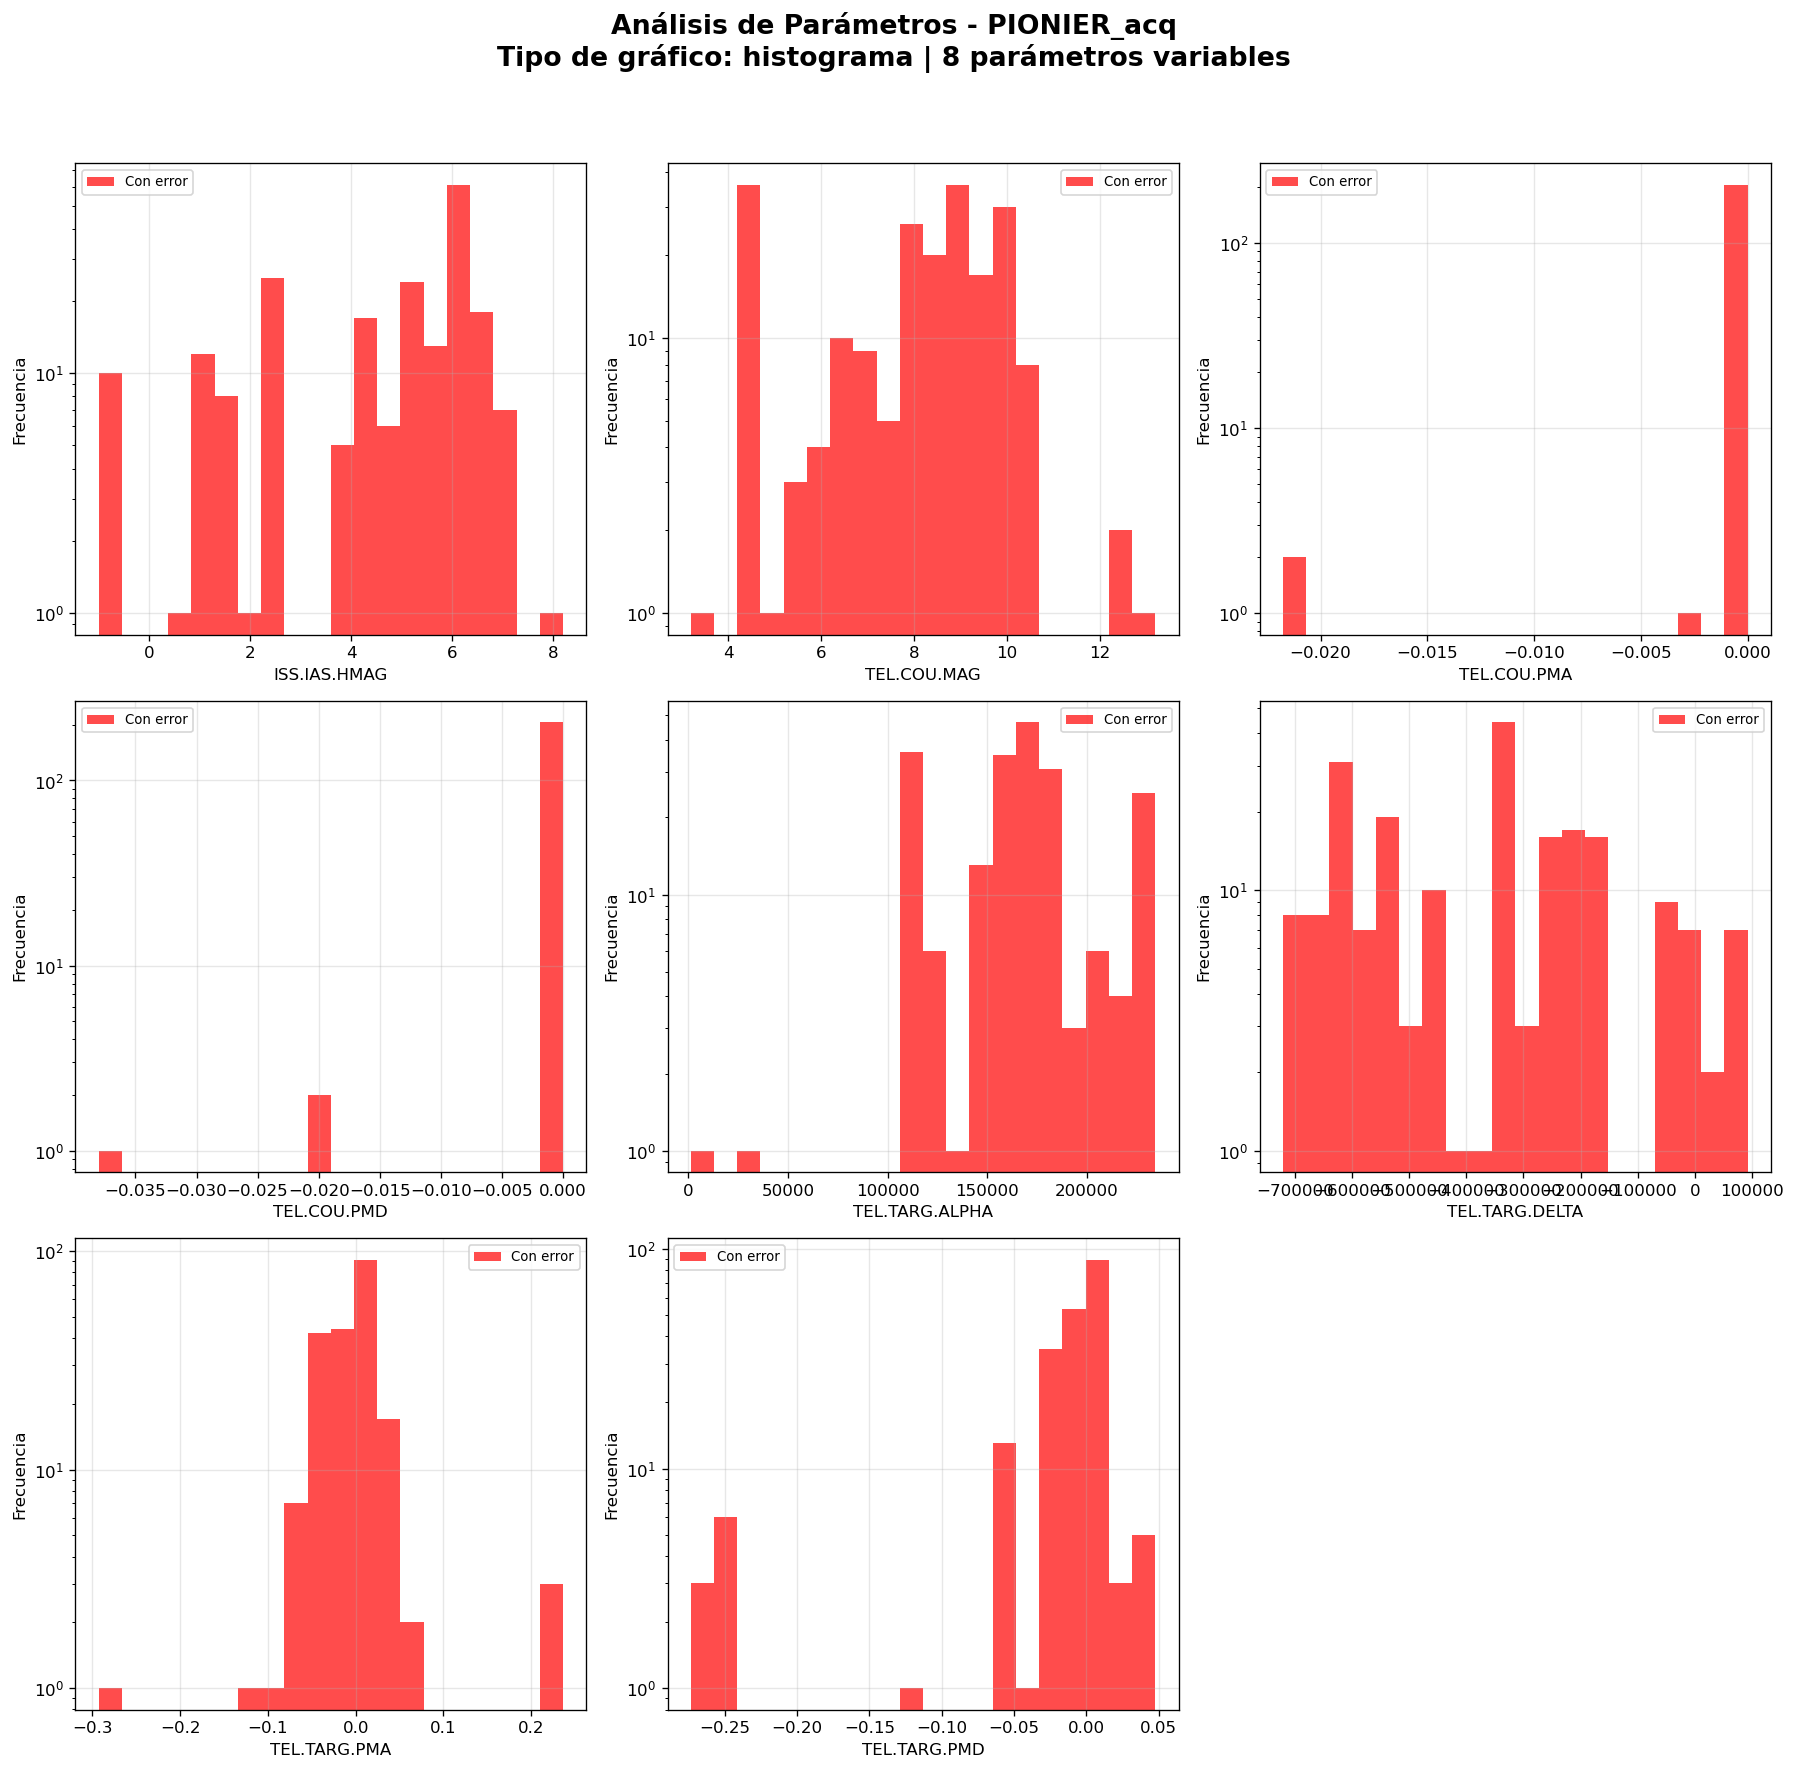

HISTOGRAMA guardado: figuras/PIONIER_acq_hist.png
Creando gráficos tipo 'histograma' para 1 parámetros NO constantes...
Figura guardada en: figuras/PIONIER_gen_tec_scan_hist.png


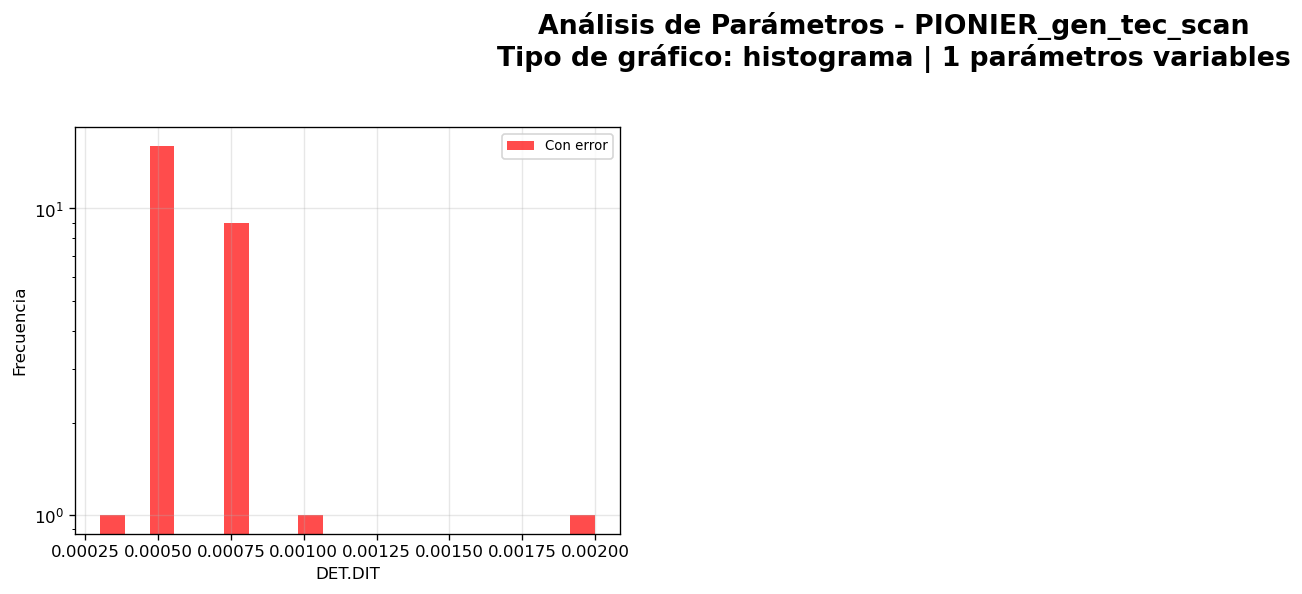

HISTOGRAMA guardado: figuras/PIONIER_gen_tec_scan_hist.png


In [8]:
CARPETA_FIG = "figuras"

for tpl_id_str in tpl_ids_validos:
    df_err = tpl_params_dict_err.get(tpl_id_str)

    if df_err is None or df_err.empty:
        print(f"{tpl_id_str}: DataFrame vacío. Se omite HISTOGRAMA.")
        continue

    df_err_num = df_err.apply(pd.to_numeric, errors="coerce")
    cols_num = sorted(df_err_num.select_dtypes(include="number").columns)

    if not cols_num:
        print(f"{tpl_id_str}: No hay columnas numéricas válidas para histograma.")
        continue

    ruta_png = f"{CARPETA_FIG}/{tpl_id_str}_hist.png"

    graficos_por_columna(
        df_sin_error=None,
        df_con_error=df_err_num[cols_num],
        nombre_archivo=tpl_id_str,
        tipo="histograma",
        log_y=True,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"HISTOGRAMA guardado: {ruta_png}")


## Extracción y análisis de parámetros categóricos

Además de los parámetros numéricos, PIONIER genera parámetros categóricos
que representan estados, procesos internos o configuraciones del sistema.

Estos se codifican, limpian (50% máximo de `NaN`) y preparan para ser
representados visualmente en gráficos tipo “pie”.


In [9]:
tpl_strval_dict_err = {}

for tpl_id in df_meta['TPL_ID'].unique():
    strval_df_err = extract_trace_categoricals(
        df_meta,      # ya está filtrado con ERROR==True
        df_traces, 
        extract_params,
        tpl_id=tpl_id
    )

    if strval_df_err is not None and not strval_df_err.empty:
        tpl_strval_dict_err[tpl_id] = strval_df_err

print(f"Se extrajeron parámetros categóricos para {len(tpl_strval_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros categóricos para 7 TPL_ID con errores.


In [10]:
codified_strval_err_dfs, dict_codificacion_err = procesar_strval_in_memory(
    tpl_strval_dict_err
)

print("\nCodificación de categóricas completada (solo errores).")
print(f"TPL_ID procesados: {len(codified_strval_err_dfs)}")



Codificación de categóricas completada (solo errores).
TPL_ID procesados: 7


## Gráficos tipo “pie” para parámetros categóricos

Los parámetros categóricos se representan mediante dos anillos concéntricos:

- **Anillo externo:** observaciones sin error  
- **Anillo interno:** observaciones con error  

Esto permite detectar si alguna categoría está asociada a la ocurrencia de
errores o si ambas distribuciones son similares.

Para evitar que categorías muy frecuentes oculten a las menos frecuentes,
se usa `log1p` sobre los conteos.


Creando gráficos tipo 'pie' para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['IAS', 'INS.MODE', 'ISS.IAS.HMAG', 'SEQ.OPL.BEAM1', 'SEQ.OPL.BEAM2', 'SEQ.OPL.BEAM3', 'SEQ.OPL.BEAM4', 'SEQ.PUPIL', 'TEL.COU.ALPHA', 'TEL.COU.DELTA', 'TEL.COU.EPOCH', 'TEL.COU.EQUINOX', 'TEL.COU.GSSOURCE', 'TEL.COU.MAG', 'TEL.COU.PMA', 'TEL.COU.PMD', 'TEL.DEL.MODE', 'TEL.DEL.REF', 'TEL.DELREF.POS', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.ALPHA', 'TEL.TARG.DELTA', 'TEL.TARG.EPOCH', 'TEL.TARG.EQUINOX', 'TEL.TARG.PMA', 'TEL.TARG.PMD']
Figura guardada en: figuras/PIONIER_acq_pie.png


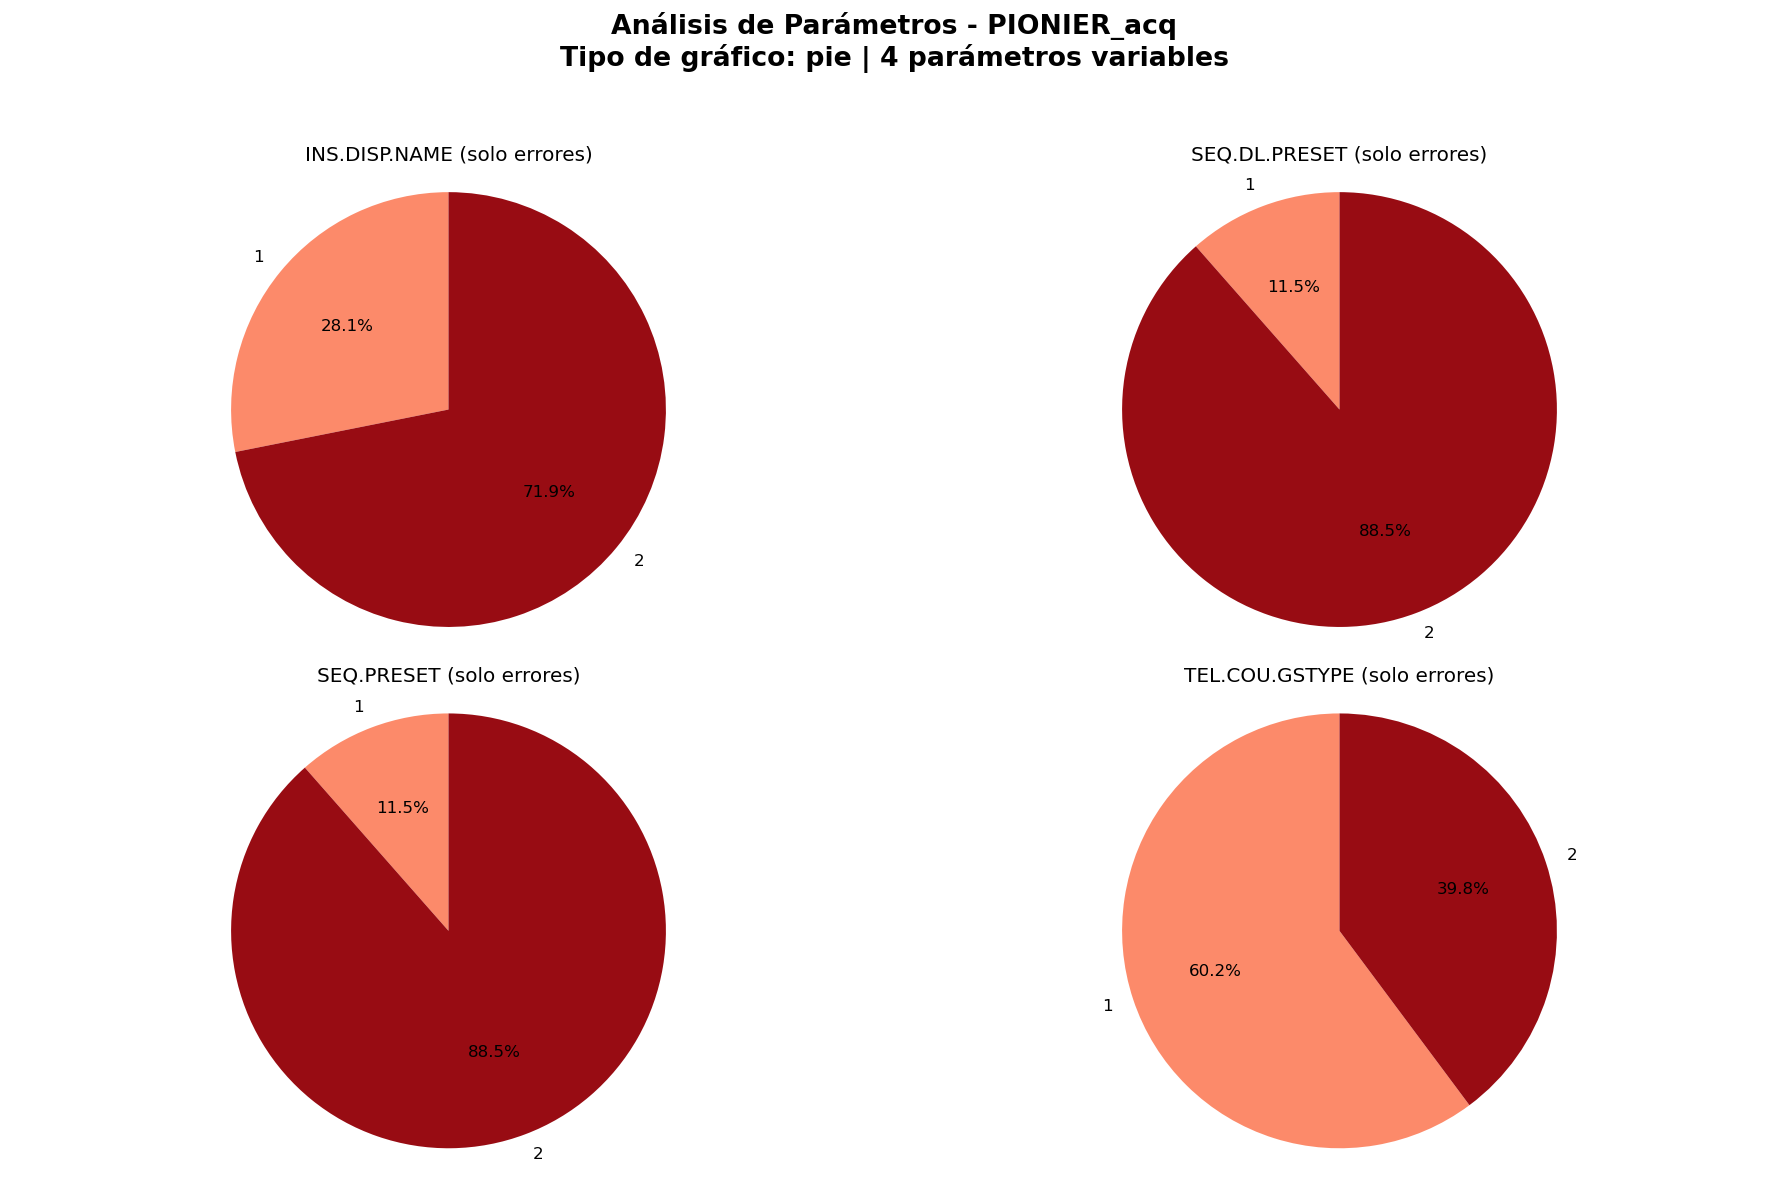

PIE guardado: figuras/PIONIER_acq_pie.png
Creando gráficos tipo 'pie' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET.DIT', 'DET.TRK.ST']
Figura guardada en: figuras/PIONIER_gen_tec_scan_pie.png


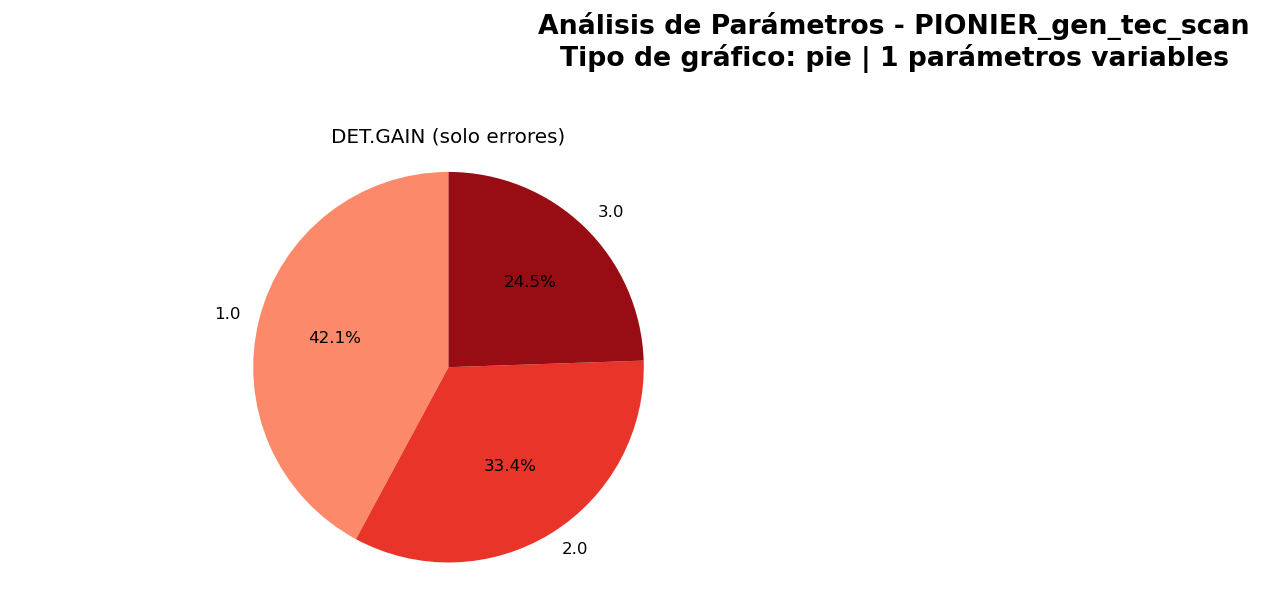

PIE guardado: figuras/PIONIER_gen_tec_scan_pie.png


In [11]:
THRESHOLD_NAN = 0.5
CARPETA_FIG = "figuras"

for tpl_id_str in tpl_ids_validos:
    df_err_codified = codified_strval_err_dfs.get(tpl_id_str)

    if df_err_codified is None or df_err_codified.empty:
        print(f"{tpl_id_str}: DataFrame vacío o inexistente. Se omite PIE.")
        continue

    df_err_cleaned = df_err_codified.loc[:, df_err_codified.isna().mean() < THRESHOLD_NAN]
    df_err_cleaned = df_err_cleaned.loc[df_err_cleaned.isna().mean(axis=1) < THRESHOLD_NAN, :]

    if df_err_cleaned.empty:
        print(f"{tpl_id_str}: DataFrame vacío después de la limpieza. Se omite PIE.")
        continue

    columns = sorted(df_err_cleaned.columns)
    if not columns:
        print(f"{tpl_id_str}: No hay columnas válidas después de la limpieza (PIE).")
        continue

    ruta_png = f"{CARPETA_FIG}/{tpl_id_str}_pie.png"

    graficos_por_columna(
        df_sin_error=None,
        df_con_error=df_err_cleaned[columns],
        nombre_archivo=tpl_id_str,
        tipo="pie",
        use_log=True,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"PIE guardado: {ruta_png}")




## Clustering de observaciones con error (DBSCAN)

GRAVITY es el instrumento donde se observa la mayor diversidad de errores,
por lo que se aplica DBSCAN por cada `TPL_ID` que cumpla el mínimo de
observaciones con error (25 o más).  
El objetivo es identificar patrones de comportamiento anómalo dentro de cada
plantilla, usando únicamente los parámetros numéricos codificados.

El procedimiento es:

1. Imputación de valores faltantes mediante la mediana.
2. Normalización de parámetros numéricos (StandardScaler).
3. Aplicación de DBSCAN en el espacio original para obtener los clusters.
4. Proyección a 2 dimensiones mediante PCA con fines visuales.
5. Uso de *jitter* para evitar la superposición de puntos en la visualización.

La etiqueta `-1` corresponde a observaciones clasificadas como **ruido**, es decir,
puntos que DBSCAN no asocia a ningún grupo denso.  
Las etiquetas válidas se asignan a los grupos detectados y luego se integran al
artefacto final (`df_report`) para su análisis y visualización en el dashboard.




Clustering (solo errores) → PIONIER_acq
DBSCAN params: {'eps': np.float64(2.196306238310292), 'min_samples': 7, 'n': 209, 'p': 8}
Conteo de clusters:
cluster
 0    167
-1     19
 1     13
 2     10
Name: count, dtype: int64
Cluster guardado en: figuras/PIONIER_acq_cluster.png


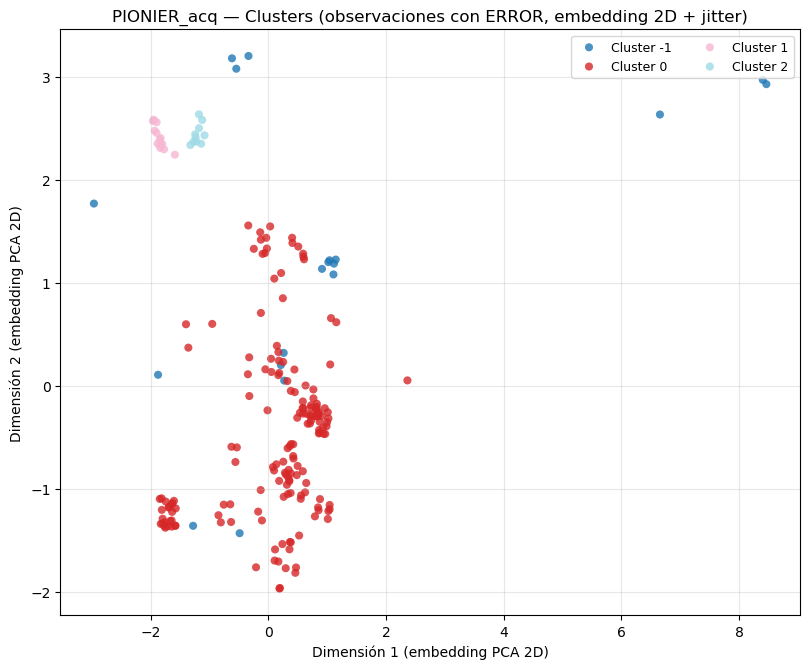

CLUSTER guardado: figuras/PIONIER_acq_cluster.png

Clustering (solo errores) → PIONIER_gen_tec_scan
Embedding 2D degenerado (1D → X, 0).
DBSCAN params: {'eps': np.float64(1.7011153966709618), 'min_samples': 4, 'n': 28, 'p': 1}
Conteo de clusters:
cluster
 0    27
-1     1
Name: count, dtype: int64
Cluster guardado en: figuras/PIONIER_gen_tec_scan_cluster.png


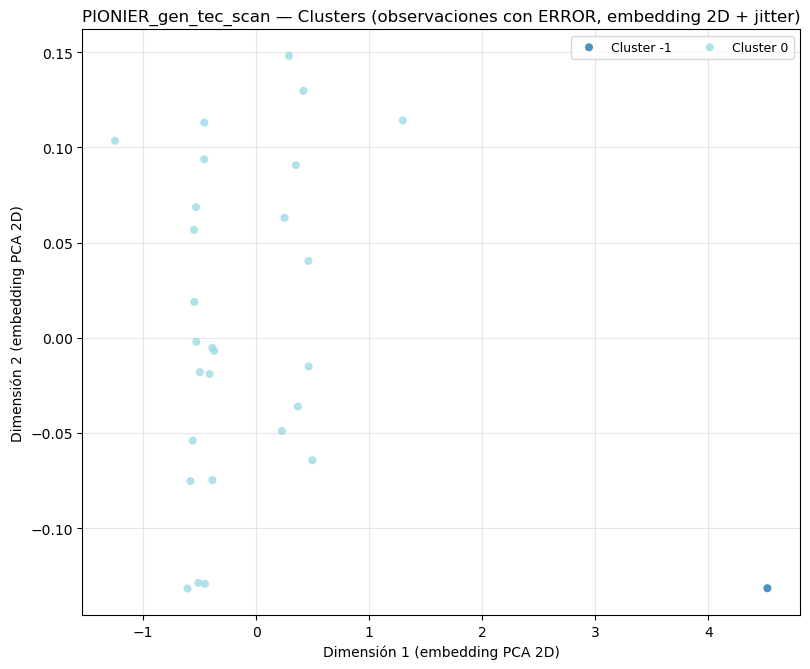

CLUSTER guardado: figuras/PIONIER_gen_tec_scan_cluster.png


In [12]:
CARPETA_FIG = "figuras"

res_por_tpl = {}

for tpl in tpl_ids_validos:
    df_err = tpl_params_dict_err.get(tpl)

    if df_err is None or df_err.empty:
        print(f"{tpl}: DataFrame vacío. Se omite CLUSTER.")
        continue

    print(f"\nClustering (solo errores) → {tpl}")
    df_res, dbp = cluster_todos_en_conjunto(None, df_err)

    if df_res.empty:
        print(f"{tpl}: sin datos utilizables después de la limpieza. Se omite CLUSTER.")
        continue

    res_por_tpl[tpl] = df_res.copy()

    print("DBSCAN params:", dbp)
    print("Conteo de clusters:")
    print(df_res["cluster"].value_counts())

    ruta_png = f"{CARPETA_FIG}/{tpl}_cluster.png"

    plot_clusters_por_cluster_y_origen(
        df_res,
        titulo=f"{tpl} — Clusters (observaciones con ERROR, embedding 2D + jitter)",
        jitter=0.15,
        save_path=ruta_png,
        mostrar=True,
    )

    print(f"CLUSTER guardado: {ruta_png}")


## Construcción del artefacto final `df_report`

Para cada `TPL_ID` se alinean los índices entre metadatos (`df_meta`), parámetros con error
(`df_err`) y resultados del clustering.  
Luego se extraen únicamente las columnas de metadatos relevantes y se combinan con los
parámetros codificados y la etiqueta de cluster asignada por DBSCAN.

El resultado es un DataFrame consolidado donde cada observación contiene:

- Metadatos seleccionados,
- Valores de parámetros utilizados en el análisis,
- Cluster asignado.

Este artefacto se utiliza posteriormente para análisis, validación y visualización en el dashboard.


In [15]:
meta_candidate_cols = ["START", "END", "system", "TPL_ID", "SECONDS", "SEQ.TARG", "SEQ.X"]
META_COLS = [c for c in meta_candidate_cols if c in df_meta.columns]

report_list = []

for tpl, df_res in res_por_tpl.items():
    df_err = tpl_params_dict_err.get(tpl)
    if df_err is None or df_err.empty or df_res.empty:
        continue

    df_res_local = df_res.copy()

    n = len(df_res_local)
    df_err_valid = df_err.iloc[-n:]   

    idx = df_err_valid.index.intersection(df_meta.index)
    if idx.empty:
        continue

    df_meta_tpl   = df_meta.loc[idx, META_COLS]
    df_params_tpl = df_err_valid.loc[idx]
    df_cluster    = df_res_local.loc[df_res_local.index.isin(idx), ["cluster"]]

    df_rep_tpl = pd.concat([df_meta_tpl, df_params_tpl, df_cluster], axis=1)
    report_list.append(df_rep_tpl)

df_report = pd.concat(report_list).sort_index()

df_report.head()

,START,END,system,TPL_ID,SECONDS,ISS.IAS.HMAG,SEQ.OPL.BEAM1,SEQ.OPL.BEAM2,SEQ.OPL.BEAM3,SEQ.OPL.BEAM4,...,TEL.TARG.ADDVELALPHA,TEL.TARG.ADDVELDELTA,TEL.TARG.ALPHA,TEL.TARG.DELTA,TEL.TARG.EPOCH,TEL.TARG.EQUINOX,TEL.TARG.PMA,TEL.TARG.PMD,cluster,DET.DIT
58,2019-04-03 01:14:09.460,2019-04-03 01:14:14.909,PIONIER,PIONIER_acq,5.0,6.550,0.0,0.0,0.0,0.0,...,0.0,0.0,181751.13,-184754.5,2000.0,2000.0,0.00368,-0.00015,0.0,NaN
1323,2019-04-27 08:31:15.023,2019-04-27 08:31:16.989,PIONIER,PIONIER_gen_tec_scan,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00100
1432,2019-04-28 01:28:43.853,2019-04-28 01:28:45.897,PIONIER,PIONIER_gen_tec_scan,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00075
1440,2019-04-28 01:40:22.828,2019-04-28 01:40:27.314,PIONIER,PIONIER_acq,4.0,5.759,0.0,0.0,0.0,0.0,...,0.0,0.0,112205.28,-244639.7,2000.0,2000.0,0.00000,0.00000,NaN,NaN
1441,2019-04-28 01:40:57.380,2019-04-28 01:41:01.820,PIONIER,PIONIER_acq,4.0,5.759,0.0,0.0,0.0,0.0,...,0.0,0.0,112205.28,-244639.7,2000.0,2000.0,0.00000,0.00000,NaN,NaN


In [16]:
import os

os.makedirs("dashboard/artefactos", exist_ok=True)

df_report.to_parquet("dashboard/artefactos/artefacto_pionier.parquet")